__Problem Statement__ 
<br>
There is a database (Name, Job title, Company, Place & Year of events) of people who attended the events organised by a company. There is also information about people who were invited to the events but did not attend the events. The aim is to use this limited information to get more insights into the type of people who are likely to attend the events. The final goal is to build a neural network model which can predict whether a person is going to attend an event based on the job title of that person.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#-----------
# USER INPUT
#-----------

xl_file = pd.ExcelFile(folder_path + 'GuestList_Data.xlsx')
data_raw = xl_file.parse('Data')

data1 = data_raw[['Job Title', 'Company', 'Year', 'Place', 'Attend']]

paramList = [0,1] # 0=Not attended, 1=attended

# Frequently position keywords
posChief = ['CMO', 'CKO', 'CTO', 'CIO', 'CEO', 'CFO', 'CSO', 'COO'] # Keywords related to "Chief ..."
posList1 = posChief + ['GM'] # CASE SENSITIVE
posList = ['Chief', 'Director', 'Head', 'Manager', 'General Manager', 'Others']

# Frequently technical keywords
techList1 = ['IT']  # CASE SENSITIVE
techList = ['Digital', 'Data', 'Technology', 'Innovation', 'Strategy',
               'Information', 'Marketing', 'Product','Service','Business', 'Others']



Import the required libraries and the excel sheet containing the data of people who were invited to the event. It contains a column "Attend" which has "1" for people who attended the event and "0" for those who didn't attend. (The excel sheet cannot be shared because of copyright issues but the approach to the problem described here can be applied elsewhere)

The first step is to use data analytics to see whether there is some correlation between the job title and the probability of people attending the event. In general, job titles (e.g. Manager of IT) contain position (Manager) and technical keywords (IT). The 'Job Title' column was analysed using wordcloud (https://github.com/amueller/word_cloud) to get a list of frequently occuring position and technical keywords (this step is not shown above for brevity).

In [2]:
def textAnalyze(data, posStats, techStats):
    '''
    Function to count the occurance of position and technical keywords in the job titles
    
    Input:
    data: Pandas dataframe containing at least the 'Job Title' and 'Attend' columns
    posStats: Pandas dataframe containing position related 'Keyword' column
    techStats: Pandas dataframe containing technical related 'Keyword' column
    
    Output:
    posStats, techStats: Dataframes with TWO more columns added ('0' and '1') to the input dataframes as shown below.
    The numbers of this dataframe represent the counts of each keywords. 
    E.g: 910 people with 'Manager' in their job title didn't attend the event. 
         101 people with 'Manager' in their job title attended the event.
    
    _________________
    |Keyword| 0 | 1 |
    _________________
    |Manager|910|101|
    |Chief  |   |   |
    |...    |   |   |
    _________________
    
    '''
    
    paramList = [0,1] # 0=Not attended, 1=attended
    
    # Step 1: Count the occurance of keywords
    for par in paramList:
        
        # Counting position keywords
        countKw = []
        for kw in posList1:
            countKw.append(data[data['Attend'] == par]['Job Title'].str.contains(kw, case = True).sum())
        for i,kw in enumerate(posList):
            if i < (len(posList)-1):
                countKw.append(data[data['Attend'] == par]['Job Title'].str.contains(kw, case = False).sum())
            else:
                others = (~(data[data['Attend'] == par]['Job Title'].str.contains('|'.join(posList), case = False) 
                          | data[data['Attend'] == par]['Job Title'].str.contains('|'.join(posList1), case = True))).sum()
                countKw.append(others)
                
        posStats[str(par)] = countKw # Add column to the input dataframe
        
        # Counting technical keywords
        countKw = []
        for kw in techList1:
            countKw.append(data[data['Attend'] == par]['Job Title'].str.contains(kw, case = True).sum())
        for i,kw in enumerate(techList):
            if i < (len(techList)-1):
                countKw.append(data[data['Attend'] == par]['Job Title'].str.contains(kw, case = False).sum())
            else:
                othersTech = (~(data[data['Attend'] == par]['Job Title'].str.contains('|'.join(techList), case = False) 
                          | data[data['Attend'] == par]['Job Title'].str.contains('|'.join(techList1), case = True))).sum()
                countKw.append(othersTech)
                
        techStats[str(par)] = countKw # Add column to the input dataframe
    
    
    # Step 2: Correct the counts of 'Manager' since it would also include 'General Manager'
    idx_manag = posStats.Keyword[posStats.Keyword == 'Manager'].index.tolist()
    idx_GenMan = posStats.Keyword[posStats.Keyword == 'General Manager'].index.tolist()

    for par in paramList:
        tmp_dif = posStats.iloc[idx_manag[0]][str(par)] - posStats.iloc[idx_GenMan[0]][str(par)]
        posStats.set_value(idx_manag[0],str(par),tmp_dif)


    # Step 3: Sum the counts of similar keywords like chief, CIO etc.
    for par in paramList:
        for kw in posChief:
            idx = posStats.Keyword[posStats.Keyword == kw].index.tolist()
            posStats[str(par)][posStats.Keyword == 'Chief'] += posStats.iloc[idx[0]][str(par)]
        
        posStats[str(par)][posStats.Keyword == 'General Manager'] = \
        posStats[((posStats.Keyword == 'GM') | (posStats.Keyword == 'General Manager'))].sum()[str(par)]
     
    
    # Step 4: Remove the rows corresponding to abbreviations like GM, CEO etc.
    removeList = posList1 
    for kw in removeList:
        posStats = posStats.drop(posStats[posStats.Keyword == kw].index)
        
    return (techStats, posStats)


#--------------
# Text analysis
#--------------

# Create two pandas dataframes with the 'Keywords' as a column.
posStats = pd.DataFrame(posList1+posList, columns = ['Keyword'])
techStats = pd.DataFrame(techList1+techList, columns = ['Keyword'])
    
# Calling the above function
techStats, posStats = textAnalyze(data1, posStats, techStats)

techStats['Success'] = techStats['1']/(techStats['0']+techStats['1'])*100
posStats['Success'] = posStats['1']/(posStats['0']+posStats['1'])*100

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


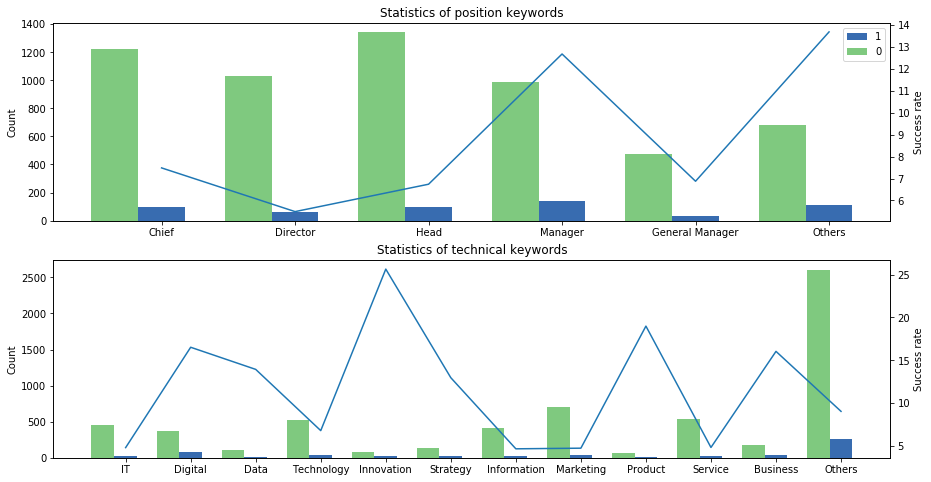

In [3]:
#-------------
# PLOT figures: Grouped BAR chart
#-------------

# IMPORT colormap
import matplotlib.cm as cm

space = 0.3
numPar = len(paramList)
width = (1 - space) / numPar

indeces1 = range(1, len(posList) + 1)
indeces2 = range(1, len(techList+techList1) + 1)

fig1, ax1 = plt.subplots(nrows=2, figsize=(15, 8))

for i,par in enumerate(paramList):
    pos = [j - (1 - space) / 2. + i * width for j in indeces1]
    ax1[0].bar(pos, posStats[str(par)], width=width, label=str(par), color=cm.Accent(float(i) / numPar))
    pos = [j - (1 - space) / 2. + i * width for j in indeces2]
    ax1[1].bar(pos, techStats[str(par)], width=width, label=str(par), color=cm.Accent(float(i) / numPar))

ax10_twin = ax1[0].twinx()
ax10_twin.plot(indeces1, posStats['Success'])
ax10_twin.set_ylabel("Success rate")

ax1[0].set_xticks(indeces1)
ax1[0].set_xticklabels(posList)
ax1[0].set_ylabel("Count")
ax1[0].set_title("Statistics of position keywords")


ax11_twin = ax1[1].twinx()
ax11_twin.plot(indeces2, techStats['Success'])
ax11_twin.set_ylabel("Success rate")

ax1[1].set_xticks(indeces2)
ax1[1].set_xticklabels(techList1+techList)
ax1[1].set_ylabel("Count")
ax1[1].set_title("Statistics of technical keywords")

# Add a legend
handles, labels = ax1[0].get_legend_handles_labels()
ax1[0].legend(handles[::-1], labels[::-1], loc='upper right')

plt.show()

The 'textAnalyze' function gives the counts of people with 'Keywords' in their job titles. The success rate (=Number of people who attended the events/ total number of invited people) is also calculated.

The above graphs show that the success rate is high among managers. The event is also popular among people related to 'digital', 'innovation', 'product' and 'business'. Hence, there is correlation between the job title and the success rate. The next step is to build a neural network which can predict the probability of an invitee attending the event based on the invitee's job title as shown below.

In [4]:
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

np.random.seed(7) # Fix the random seed for reproducibility


'''
Implement recall measure in keras
Accuracy measure might be misleading for imbalanced datasets
reference: https://github.com/fchollet/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7
'''
import keras.backend as K
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

Using TensorFlow backend.


In [5]:
'''
The data is ordered i.e. Attendees appear first. Use random sampling to shuffle the rows
Set the random_state for reproducibility
'''
data = data1.sample(frac=1,random_state=7).reset_index(drop=True)

# Step 1: Preprocess the title words

top_words = 500 # Keep only the top 500 frequently occuring words in the job titles
max_words = 7 # Max words in a given job title.

tokeniz = Tokenizer(num_words=top_words, split=' ')
tokeniz.fit_on_texts(data['Job Title'].values)

X_data = tokeniz.texts_to_sequences(data['Job Title'].values)
X_data = pad_sequences(X_data, maxlen=max_words)

y_data = data['Attend']

# 80% of the dataset is used for training the CNN
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,train_size=0.8)

print('Counts of each category:',np.unique(y_train,return_counts=True))

Counts of each category: (array([0, 1]), array([4463,  430]))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
# Step 2: Create CNN model

model = Sequential()

# Different weights are needed due to imbalanced dataset
class_weight = {0 : 1.0, 1: 3.0}

model.add(Embedding(top_words, 32, input_length=max_words))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# Additional metrics like recall and precision are used since the dataset is imbalanced
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall,precision])

print(model.summary())


# Step 3: Train the CNN model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, class_weight = class_weight)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy of the CNN on the test set is", scores[1]*100, '%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 7, 32)             16000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 32)             3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 25,377
Trainable params: 25,377
Non-trainable params: 0
_________________________________________________________________
None
E

A convolutional neural network (CNN) is faster to train and works well for text analysis. The CNN used here has an embedding layer, a 1 D convolutional layer with 32 filters and a dense layer with 64 neurons. The job title has very few words due to which a shallow neural network is sufficient. Deep neural networks can be used while analyzing longer texts.

According to the dataset, 4463 people didn't attend the events and 432 people attended the events. There is a bias in the dataset and a equally weighted CNN would have a misleading higher accuracy in spite of poor performance (It can just predict '0' for all cases and yet achieve 91% accuracy (=4463/(4463+432)*100). Hence, the two classes (0 & 1) should have different weights, and recall and precision should be used as additional metrics while dealing with classification problems having imbalanced data.

The present CNN has acceptable accuracy, recall and precision values on the training dataset. The accuracy on the test set is around 88%. Further optimisation of CNN architecture might result in better metrics values.

The sales team can input the job title of a person to this CNN model and check whether he/she would attend an event if invited. The sales team can give higher priority to such people and contact them first, thereby increasing the effectiveness of sales.

This CNN model uses just the job title as an input due to which it has lower precision and recall values. The performance of this model could be improved by using more inputs like age, years of job experience, educational qualification etc. of a person.